In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Downloads/monthly_milk_production.csv', encoding='unicode_escape', index_col='Date',parse_dates=True)
df.index.freq='MS'

In [50]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


<Axes: xlabel='Date'>

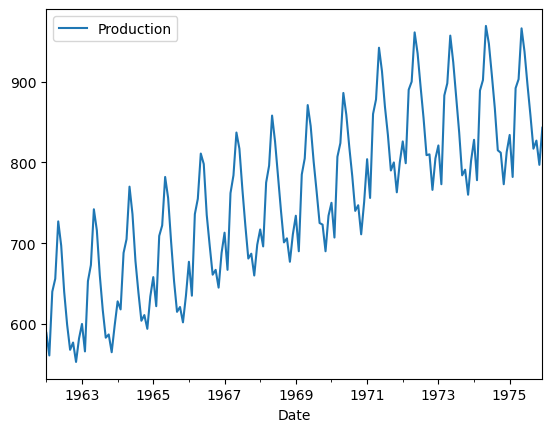

In [4]:
df.plot()

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

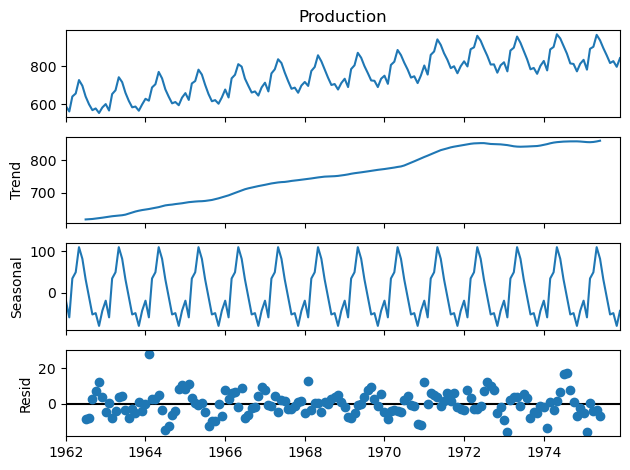

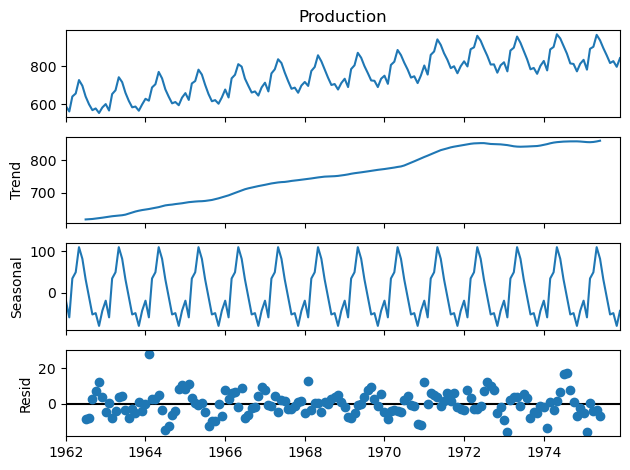

In [6]:
results = seasonal_decompose(df['Production'])
results.plot()

In [7]:
len(df)

168

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
[[0.24759615]]


In [18]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.01923077 0.20913462 0.24759615]
Predict this y: 
[[0.41826923]]


In [19]:
X.shape

(1, 3, 1)

In [21]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [24]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.fit(generator, epochs=50)

Epoch 1/50

144/144 [==============================] - 4s 6ms/step - loss: 0.0464
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0225
Epoch 3/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0179
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0121
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0074
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 8/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0041
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 11/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 12/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0038
Epoch 13/50
144/144 [==

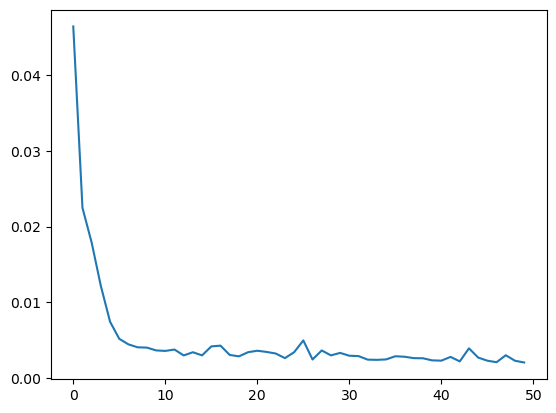

In [28]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [29]:
last_train_batch = scaled_train[-12:]

In [30]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 333ms/step


array([[0.61108077]], dtype=float32)

In [32]:
scaled_test[0]

array([0.67548077])

In [42]:
test_predictions =[]
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 34ms/step


In [43]:
test_predictions

[array([0.61108077], dtype=float32),
 array([0.58906317], dtype=float32),
 array([0.78338504], dtype=float32),
 array([0.87464666], dtype=float32),
 array([0.98613954], dtype=float32),
 array([0.96365404], dtype=float32),
 array([0.88381326], dtype=float32),
 array([0.7600261], dtype=float32),
 array([0.6502348], dtype=float32),
 array([0.61002123], dtype=float32),
 array([0.5613767], dtype=float32),
 array([0.5926862], dtype=float32)]

In [45]:
true_predictions = scaler.inverse_transform(test_predictions)

In [46]:
test['Predictions']= true_predictions

C:\Users\admin\AppData\Local\Temp\ipykernel_14320\715416204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']= true_predictions


In [47]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,807.209599
1975-02-01,782,798.050278
1975-03-01,892,878.888176
1975-04-01,903,916.853012
1975-05-01,966,963.234047


<Axes: xlabel='Date'>

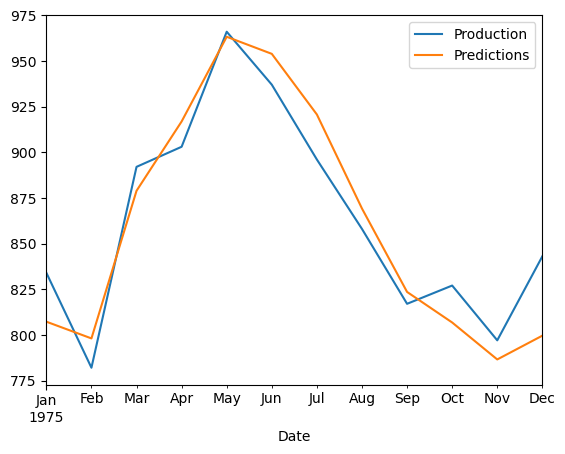

In [48]:
test.plot()

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme = sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rsme)

20.02770015997602
